In [1]:
import os
import re
import sys
import numpy as np
import pydot
import rmgpy.tools.fluxdiagram
import rmgpy.chemkin
from rmgpy.solver.base import TerminationTime
from rmgpy.solver.liquid import LiquidReactor
from rmgpy.kinetics.diffusionLimited import diffusion_limiter

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/home/moon/autoscience/reaction_calculator/database')
import database_fun

using default DFT_DIR


## Settings

In [2]:
# Options controlling the individual flux diagram renderings:
program = 'dot'  # The program to use to lay out the nodes and edges
max_node_count = 50  # The maximum number of nodes to show in the diagram
max_edge_count = 50  # The maximum number of edges to show in the diagram
concentration_tol = 1e-6  # The lowest fractional concentration to show (values below this will appear as zero)
species_rate_tol = 1e-6  # The lowest fractional species rate to show (values below this will appear as zero)
max_node_pen_width = 10.0  # The thickness of the border around a node at maximum concentration
max_edge_pen_width = 10.0  # The thickness of the edge at maximum species rate
radius = 1  # The graph radius to plot around a central species
central_reaction_count = None  # The maximum number of reactions to draw from each central species (None draws all)
# If radius > 1, then this is the number of reactions from every species

# Options controlling the ODE simulations:
initial_time = 1e-12  # The time at which to initiate the simulation, in seconds
time_step = 10 ** 0.1  # The multiplicative factor to use between consecutive time points
abs_tol = 1e-16  # The absolute tolerance to use in the ODE simluations
rel_tol = 1e-8  # The relative tolerance to use in the ODE simulations

# Options controlling the generated movie:
video_fps = 6  # The number of frames per second in the generated movie
initial_padding = 5  # The number of seconds to display the initial fluxes at the start of the video
final_padding = 5  # The number of seconds to display the final fluxes at the end of the video


species_path = None
java = False            # always False
settings = None
chemkin_output = ''     # this will be generated automatically
central_species_list = None
superimpose = False     # this will always be false, delete it
save_states = False
read_states = False     # fine to keep this always false and delete relevant code below
diffusion_limited = True
check_duplicates = True

CC(CCOO)O[O] + CC(CCOO)OO <=> CC(CCO[O])OO + CC(CCOO)OO


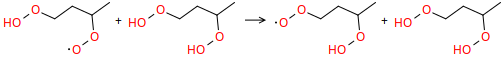

In [3]:
n=4750
print(database_fun.index2reaction(n))
display(database_fun.index2reaction(n))

In [4]:
database_fun.get_unique_species_index(rmgpy.species.Species(smiles='CCCCOO'))

280

In [5]:
display(database_fun.index2species())

TypeError: index2species() missing 1 required positional argument: 'index'

## Load Mechanisms

In [6]:
# rmg_input_file = '/home/moon/autoscience/fuels/butane_20240403/simplified_input.py'  # for conditions
rmg_input_file = '/home/moon/autoscience/reaction_calculator/flux/simplified_input.py'

diagram_base_name = 'without7_vs_aramco'
# diagram_base_name = 'without7_vs_aramco_hightol'
os.makedirs(diagram_base_name, exist_ok=True)
mech_1_inp = '/home/moon/autoscience/aramco/truncated/aramco_truncated.inp'
mech_1_dict = '/home/moon/autoscience/aramco/species_dictionary.txt'
mech_1_label = 'aramco'
t1_match = 0.06535855787324196
mech_2_inp = '/home/moon/autoscience/fuels/butane_20240501/chem_annotated.inp'
mech_2_dict = '/home/moon/autoscience/fuels/butane_20240501/species_dictionary.txt'
mech_2_label = 'no lib 20240501'
t2_match = 0.02934108246263338


# diagram_base_name = 'without7_no324_vs_aramco'
# os.makedirs(diagram_base_name, exist_ok=True)
# mech_1_inp = '/home/moon/autoscience/aramco/truncated/aramco_truncated.inp'
# mech_1_dict = '/home/moon/autoscience/aramco/species_dictionary.txt'
# mech_1_label = 'aramco'
# t1_match = 0.06535855787324196
# mech_2_inp = '/home/moon/autoscience/fuels/butane_investigation/chem_annotated_no324.inp'
# mech_2_dict = '/home/moon/autoscience/fuels/butane_investigation/species_dictionary.txt'
# mech_2_label = 'no lib 20240501'
# t2_match = 0.02934108246263338


# diagram_base_name = 'without7_vs_aramco_830K_20bar'
# os.makedirs(diagram_base_name, exist_ok=True)
# mech_1_inp = '/home/moon/autoscience/aramco/truncated/aramco_truncated.inp'
# mech_1_dict = '/home/moon/autoscience/aramco/species_dictionary.txt'
# mech_1_label = 'aramco'
# t1_match = 0.06535855787324196
# mech_2_inp = '/home/moon/autoscience/fuels/butane_investigation/chem_annotated_no324.inp'
# mech_2_dict = '/home/moon/autoscience/fuels/butane_investigation/species_dictionary.txt'
# mech_2_label = 'no lib 20240501'
# t2_match = 0.02934108246263338


# diagram_base_name = 'without7_323449_vs_aramco'
# # diagram_base_name = 'without7_vs_aramco_hightol'
# os.makedirs(diagram_base_name, exist_ok=True)
# mech_1_inp = '/home/moon/autoscience/aramco/truncated/aramco_truncated.inp'
# mech_1_dict = '/home/moon/autoscience/aramco/species_dictionary.txt'
# mech_1_label = 'aramco'
# t1_match = 0.06535855787324196
# mech_2_inp = '/home/moon/autoscience/fuels/butane_investigation/chem_annotated_323449.inp'
# mech_2_dict = '/home/moon/autoscience/fuels/butane_investigation/species_dictionary.txt'
# mech_2_label = 'no lib 20240501'
# t2_match = 0.02934108246263338

# diagram_base_name = 'without7_thermokinetics_vs_aramco'
# # diagram_base_name = 'without7_vs_aramco_hightol'
# os.makedirs(diagram_base_name, exist_ok=True)
# mech_1_inp = '/home/moon/autoscience/aramco/truncated/aramco_truncated.inp'
# mech_1_dict = '/home/moon/autoscience/aramco/species_dictionary.txt'
# mech_1_label = 'aramco'
# t1_match = 0.06535855787324196
# mech_2_inp = '/home/moon/autoscience/fuels/butane_investigation/chem_annotated_thermokinetics.inp'
# mech_2_dict = '/home/moon/autoscience/fuels/butane_investigation/species_dictionary.txt'
# mech_2_label = 'no lib 20240501'
# t2_match = 0.02934108246263338



# diagram_base_name = 'without1_vs_aramco'
# os.makedirs(diagram_base_name, exist_ok=True)
# mech_1_inp = '/home/moon/autoscience/aramco/truncated/aramco_truncated.inp'
# mech_1_dict = '/home/moon/autoscience/aramco/species_dictionary.txt'
# mech_1_label = 'aramco'
# t1_match = 0.06535855787324196
# mech_2_inp = '/home/moon/autoscience/fuels/butane_20240126/chem_annotated.inp'
# mech_2_dict = '/home/moon/autoscience/fuels/butane_20240126/species_dictionary.txt'
# mech_2_label = 'no lib 20240126'
# t2_match = 0.006677756747669057

# diagram_base_name = 'without_plus281_vs_aramco'
# os.makedirs(diagram_base_name, exist_ok=True)
# mech_1_inp = '/home/moon/autoscience/aramco/truncated/aramco_truncated.inp'
# mech_1_dict = '/home/moon/autoscience/aramco/species_dictionary.txt'
# mech_1_label = 'aramco'
# mech_2_inp = '/home/moon/autoscience/fuels/curran_281/chem_annotated.inp'
# mech_2_dict = '/home/moon/autoscience/fuels/curran_281/species_dictionary.txt'
# mech_2_label = 'no lib 20240501 - curran 281'


# diagram_base_name = 'with_vs_aramco'
# os.makedirs(diagram_base_name, exist_ok=True)
# mech_1_inp = '/home/moon/autoscience/aramco/truncated/aramco_truncated.inp'
# mech_1_dict = '/home/moon/autoscience/aramco/species_dictionary.txt'
# mech_1_label = 'aramco'
# t1_match = 0.06535855787324196
# mech_2_inp = '/home/moon/autoscience/fuels/with_lib/butane_20240413/chem_annotated.inp'
# mech_2_dict = '/home/moon/autoscience/fuels/with_lib/butane_20240413/species_dictionary.txt'
# mech_2_label = 'with lib 20240413'
# t2_match = 0.1062952253947189


# diagram_base_name = 'without1_vs_without7'
# os.makedirs(diagram_base_name, exist_ok=True)
# mech_1_inp = '/home/moon/autoscience/fuels/butane_20240126/chem_annotated.inp'
# mech_1_dict = '/home/moon/autoscience/fuels/butane_20240126/species_dictionary.txt'
# mech_1_label = 'no lib 20240126'
# t1_match = 0.006677756747669057
# mech_2_inp = '/home/moon/autoscience/fuels/butane_20240501/chem_annotated.inp'
# mech_2_dict = '/home/moon/autoscience/fuels/butane_20240501/species_dictionary.txt'
# mech_2_label = 'no lib 20240501'
# t2_match = 0.02934108246263338



# diagram_base_name = 'without7_vs_without1'
# os.makedirs(diagram_base_name, exist_ok=True)

# mech_1_inp = '/home/moon/autoscience/fuels/butane_20240501/chem_annotated.inp'
# mech_1_dict = '/home/moon/autoscience/fuels/butane_20240501/species_dictionary.txt'
# mech_1_label = 'no lib 20240501'
# t1_match = 0.02934108246263338
# mech_2_inp = '/home/moon/autoscience/fuels/butane_20240126/chem_annotated.inp'
# mech_2_dict = '/home/moon/autoscience/fuels/butane_20240126/species_dictionary.txt'
# mech_2_label = 'no lib 20240126'
# t2_match = 0.006677756747669057

# diagram_base_name = 'without7_vs_rerun'
# os.makedirs(diagram_base_name, exist_ok=True)
# mech_1_inp = '/home/moon/autoscience/fuels/butane_20240501/chem_annotated.inp'
# mech_1_dict = '/home/moon/autoscience/fuels/butane_20240501/species_dictionary.txt'
# mech_1_label = 'no lib 20240501'
# t1_match = 0.02934108246263338
# mech_2_inp = '/home/moon/autoscience/fuels/butane_20240501/rerun/chem_annotated.inp'
# mech_2_dict = '/home/moon/autoscience/fuels/butane_20240501/rerun/species_dictionary.txt'
# mech_2_label = 'no lib 20240501 - no duplicates rerun'
# t2_match = 0.02104963847393351



# diagram_base_name = 'without7_vs_curran281'
# os.makedirs(diagram_base_name, exist_ok=True)
# mech_1_inp = '/home/moon/autoscience/fuels/butane_20240501/chem_annotated.inp'
# mech_1_dict = '/home/moon/autoscience/fuels/butane_20240501/species_dictionary.txt'
# mech_1_label = 'no lib 20240501'
# t1_match = 0.02934108246263338
# mech_2_inp = '/home/moon/autoscience/fuels/curran_281/chem_annotated.inp'
# mech_2_dict = '/home/moon/autoscience/fuels/curran_281/species_dictionary.txt'
# mech_2_label = 'no lib 20240501 - curran 281'
# t2_match = 0.018686798930463266

# mech_2_inp = '/home/moon/autoscience/fuels/with_lib/butane_20240413/chem_annotated.inp'
# mech_2_dict = '/home/moon/autoscience/fuels/with_lib/butane_20240413/species_dictionary.txt'
# mech_2_label = 'with lib 20240413'

# mech_1_inp = '/home/moon/autoscience/fuels/butane_20240501/chem_annotated.inp'
# mech_1_dict = '/home/moon/autoscience/fuels/butane_20240501/species_dictionary.txt'


if species_path is None:
    species_path = os.path.join(os.path.dirname(rmg_input_file), 'species')
    generate_images = True
else:
    generate_images = False

print('Loading RMG job 1...')
rmg_job1 = rmgpy.tools.fluxdiagram.load_rmg_job(
    rmg_input_file,
    mech_1_inp,
    mech_1_dict,
    generate_images=generate_images,
    check_duplicates=check_duplicates
)

print('Loading RMG job 2...')
rmg_job2 = rmgpy.tools.fluxdiagram.load_rmg_job(
    rmg_input_file,
    mech_2_inp,
    mech_2_dict,
    generate_images=generate_images,
    check_duplicates=check_duplicates
)

Loading RMG job 1...


┌ Warning: Replacing docs for `ReactionMechanismSimulator.getpairs :: Tuple{T} where T<:ReactionMechanismSimulator.AbstractReaction` in module `ReactionMechanismSimulator`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `ReactionMechanismSimulator.getsimilarity :: Union{Tuple{T2}, Tuple{T}, Tuple{T, T2}} where {T<:ReactionMechanismSimulator.AbstractSpecies, T2<:ReactionMechanismSimulator.AbstractSpecies}` in module `ReactionMechanismSimulator`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `SciMLBase.sol :: Union{Tuple, Tuple{D}, Tuple{S}, Tuple{N}, Tuple{T}} where {T, N, S, D}` in module `SciMLBase`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: DiffEqOperators.jl is in the process of being deprecated.
│ 
│        - For automated PDE discretization, see MethodOfLines.jl
│ 
│        - For MatrixFreeOperators, and other non-derivative operators, see SciMLOperators.jl
│ 
│        - For VecJacOperators and JacVecOperators, see SparseDiffTools.jl
└ @ DiffEqOperators ~

┌ Warning: Replacing docs for `ReactionMechanismSimulator.plotrops :: Union{Tuple{X}, Tuple{Y}, Tuple{Y, X}} where {Y<:ReactionMechanismSimulator.Simulation, X<:AbstractString}` in module `ReactionMechanismSimulator`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `ReactionMechanismSimulator.plotrops :: Union{Tuple{X}, Tuple{Y}, Tuple{Y, X}} where {Y<:ReactionMechanismSimulator.Simulation, X<:AbstractString}` in module `ReactionMechanismSimulator`
└ @ Base.Docs docs/Docs.jl:240


Loading RMG job 2...


## Simulation

In [7]:
print('Conducting simulation of reaction 1')
times1, concentrations1, reaction_rates1 = rmgpy.tools.fluxdiagram.simulate(
    rmg_job1.reaction_model,
    rmg_job1.reaction_systems[0],
    settings
)

print('Conducting simulation of reaction 2')
times2, concentrations2, reaction_rates2 = rmgpy.tools.fluxdiagram.simulate(
    rmg_job2.reaction_model,
    rmg_job2.reaction_systems[0],
    settings
)

Conducting simulation of reaction 1
Conducting simulation of reaction 2


In [8]:
# Get the species and reactions corresponding to the provided concentrations and reaction rates
species_list1 = rmg_job1.reaction_model.core.species[:]
reaction_list1 = rmg_job1.reaction_model.core.reactions[:]
num_species1 = len(species_list1)

species_list2 = rmg_job2.reaction_model.core.species[:]
reaction_list2 = rmg_job2.reaction_model.core.reactions[:]
num_species2 = len(species_list2)

In [9]:
# Compute the rates between each pair of species (big matrix warning!)
species_rates1 = np.zeros((len(times1), num_species1, num_species1), float)
for index1, reaction1 in enumerate(reaction_list1):
    rate1 = reaction_rates1[:, index1]
    if not reaction1.pairs: reaction1.generate_pairs()
    for reactant1, product1 in reaction1.pairs:
        reactant_index1 = species_list1.index(reactant1)
        product_index1 = species_list1.index(product1)
        species_rates1[:, reactant_index1, product_index1] += rate1
        species_rates1[:, product_index1, reactant_index1] -= rate1
        
species_rates2 = np.zeros((len(times2), num_species2, num_species2), float)
for index2, reaction2 in enumerate(reaction_list2):
    rate2 = reaction_rates2[:, index2]
    if not reaction2.pairs: reaction2.generate_pairs()
    for reactant2, product2 in reaction2.pairs:
        reactant_index2 = species_list2.index(reactant2)
        product_index2 = species_list2.index(product2)
        species_rates2[:, reactant_index2, product_index2] += rate2
        species_rates2[:, product_index2, reactant_index2] -= rate2

In [10]:
# Determine the maximum concentration for each species and the maximum overall concentration
max_concentrations1 = np.max(np.abs(concentrations1), axis=0)
max_concentration1 = np.max(max_concentrations1)

# Determine the maximum reaction rates
max_reaction_rates1 = np.max(np.abs(reaction_rates1), axis=0)

# Determine the maximum rate for each species-species pair and the maximum overall species-species rate
max_species_rates1 = np.max(np.abs(species_rates1), axis=0)
max_species_rate1 = np.max(max_species_rates1)
species_index1 = max_species_rates1.reshape((num_species1 * num_species1)).argsort()


max_concentrations2 = np.max(np.abs(concentrations2), axis=0)
max_concentration2 = np.max(max_concentrations2)

# Determine the maximum reaction rates
max_reaction_rates2 = np.max(np.abs(reaction_rates2), axis=0)

# Determine the maximum rate for each species-species pair and the maximum overall species-species rate
max_species_rates2 = np.max(np.abs(species_rates2), axis=0)
max_species_rate2 = np.max(max_species_rates2)
species_index2 = max_species_rates2.reshape((num_species2 * num_species2)).argsort()


In [11]:
# Determine the nodes and edges to keep
nodes1 = []
edges1 = []
for i in range(num_species1 * num_species1):
    product_index1, reactant_index1 = divmod(species_index1[-i - 1], num_species1)
    if reactant_index1 > product_index1:
        # Both reactant -> product and product -> reactant are in this list,
        # so only keep one of them
        continue
    if max_species_rates1[reactant_index1, product_index1] == 0:
        break
    if reactant_index1 not in nodes1 and len(nodes1) < max_node_count: nodes1.append(reactant_index1)
    if product_index1 not in nodes1 and len(nodes1) < max_node_count: nodes1.append(product_index1)
    if [reactant_index1, product_index1] not in edges1 and [product_index1, reactant_index1] not in edges1:
        edges1.append([reactant_index1, product_index1])
    if len(nodes1) > max_node_count:
        break
    if len(edges1) >= max_edge_count:
        break
        
nodes2 = []
edges2 = []
for i in range(num_species2 * num_species2):
    product_index2, reactant_index2 = divmod(species_index2[-i - 1], num_species2)
    if reactant_index2 > product_index2:
        # Both reactant -> product and product -> reactant are in this list,
        # so only keep one of them
        continue
    if max_species_rates2[reactant_index2, product_index2] == 0:
        break
    if reactant_index2 not in nodes2 and len(nodes2) < max_node_count: nodes2.append(reactant_index2)
    if product_index2 not in nodes2 and len(nodes2) < max_node_count: nodes2.append(product_index2)
    if [reactant_index2, product_index2] not in edges2 and [product_index2, reactant_index2] not in edges2:
        edges2.append([reactant_index2, product_index2])
    if len(nodes2) > max_node_count:
        break
    if len(edges2) >= max_edge_count:
        break


In [12]:
species2_to_1 = {}
for i in range(len(species_list2)):
    for j in range(len(species_list1)):
        if species_list2[i].is_isomorphic(species_list1[j]):
            species2_to_1[i] = j
            break
    else:
        species2_to_1[i] = -1

In [13]:
# edit nodes in 2 to match nodes in 1  and just thread them through to each other...
nodes2_edited = []
edges2_edited = []

for n2 in nodes2:
    # check if the species it refers to is in n1
    if species2_to_1[n2] > 0:
        nodes2_edited.append(species2_to_1[n2])
    else:
        nodes2_edited.append(n2)

for e2 in edges2:
    # check if the species it refers to is in n1
    new_edge = [e2[0], e2[1]]
    if species2_to_1[e2[0]] > 0:
        new_edge[0] = species2_to_1[e2[0]]
    if species2_to_1[e2[1]] > 0:
        new_edge[1] = species2_to_1[e2[1]]
    edges2_edited.append(new_edge)


In [14]:
# Create the master graph all at once
my_red = '#ff000080'
my_blue = '#0000ff80'

t1s = np.arange(np.abs(times1 - t1_match).argmin() - 20, np.abs(times1 - t1_match).argmin() + 3)
t2s = np.arange(np.abs(times2 - t2_match).argmin() - 20, np.abs(times2 - t2_match).argmin() + 3)
# t1s = [len(times1) - 1]
# t2s = [len(times2) - 1]
for t in range(len(t1s)):
    slope = -max_node_pen_width / np.log10(concentration_tol)
    
    t1 = t1s[t]
    t2 = t2s[t]

    graph = pydot.Dot('flux_diagram', graph_type='digraph', overlap="false")
    graph.set_rankdir('LR')
    graph.set_fontname('sans')
    graph.set_fontsize('10')


    # Add a node for each species
    for index1 in nodes1:
        species1 = species_list1[index1]
        node1 = pydot.Node(name=str(species1))
        concentration1 = concentrations1[t1, index1] / max_concentration1
        if concentration1 < concentration_tol:
            penwidth = 0.0
        else:
            penwidth = round(slope * np.log10(concentration1) + max_node_pen_width, 3)
        node1.set_penwidth(penwidth)
        
        # Try to use an image instead of the label
        species_index1 = str(species1) + '.png'
        image_path1 = ''
        if not species_path or not os.path.exists(species_path):
            continue
        for root, dirs, files in os.walk(species_path):
            for f in files:
                if f == species_index1:
                    image_path1 = os.path.join(root, f)
                    break
        if os.path.exists(image_path1):
            node1.set_image(image_path1)
            node1.set_label(" ")
        graph.add_node(node1)

    for index2 in nodes2:
        if species2_to_1[index2] > 0:
            species2 = species_list1[species2_to_1[index2]]
            names = [x.get_name() for x in graph.get_node_list()]
            if str(species2) in names:
                continue  # node is already in graph
        else:
            species2 = species_list2[index2]
        node2 = pydot.Node(name=str(species2))  # check if it's already in there?? probably doesn't matter. We're overwriting
        concentration2 = concentrations2[t2, index2] / max_concentration2
        if concentration2 < concentration_tol:
            penwidth = 0.0
        else:
            penwidth = round(slope * np.log10(concentration2) + max_node_pen_width, 3)
        node2.set_penwidth(penwidth)
        
        # Try to use an image instead of the label
        species_index2 = str(species2) + '.png'
        image_path2 = ''
        if not species_path or not os.path.exists(species_path):
            continue
        for root, dirs, files in os.walk(species_path):
            for f in files:
                if f == species_index2:
                    image_path2 = os.path.join(root, f)
                    break
        if os.path.exists(image_path2):
            node2.set_image(image_path2)
            node2.set_label(" ")
        graph.add_node(node2)


    # Add an edge for each species-species rate
    slope = -max_edge_pen_width / np.log10(species_rate_tol)
    for reactant_index1, product_index1 in edges1:
        if reactant_index1 in nodes1 and product_index1 in nodes1:
            reactant1 = species_list1[reactant_index1]
            product1 = species_list1[product_index1]
            edge1 = pydot.Edge(str(reactant1), str(product1), color=my_red)
            species_rate1 = species_rates1[t1, reactant_index1, product_index1] / max_species_rate1
            if species_rate1 < 0:
                edge1.set_dir("back")
                species_rate1 = -species_rate1
            else:
                edge1.set_dir("forward")
            # Set the edge pen width
            if species_rate1 < species_rate_tol:
                penwidth = 0.0
                edge1.set_dir("none")
            else:
                penwidth = round(slope * np.log10(species_rate1) + max_edge_pen_width, 3)
            edge1.set_penwidth(penwidth)
            
            graph.add_edge(edge1)

    
    for reactant_index2, product_index2 in edges2:
        if reactant_index2 in nodes2 and product_index2 in nodes2:
            if species2_to_1[reactant_index2] > 0:
                reactant2 = species_list1[species2_to_1[reactant_index2]]
            else:
                reactant2 = species_list2[reactant_index2]
            
            if species2_to_1[product_index2] > 0:
                product2 = species_list1[species2_to_1[product_index2]]
            else:
                product2 = species_list2[product_index2]
            edge2 = pydot.Edge(str(reactant2), str(product2), color=my_blue)
            species_rate2 = species_rates2[t2, reactant_index2, product_index2] / max_species_rate2
            if species_rate2 < 0:
                edge2.set_dir("back")
                species_rate2 = -species_rate2
            else:
                edge2.set_dir("forward")
            # Set the edge pen width
            if species_rate2 < species_rate_tol:
                penwidth = 0.0
                edge2.set_dir("none")
            else:
                penwidth = round(slope * np.log10(species_rate2) + max_edge_pen_width, 3)
            edge2.set_penwidth(penwidth)
            graph.add_edge(edge2)
            
    # Generate the coordinates for all of the nodes using the specified program
    graph = pydot.graph_from_dot_data(graph.create_dot(prog=program).decode('utf-8'))[0]
    
    graph.add_node(pydot.Node(mech_1_label + f'\nt={times1[t1]:.4e}', label=mech_1_label + f'\nt={times1[t1]:.4e}', color=my_red, shape='box', penwidth=max_node_pen_width))
    graph.add_node(pydot.Node(mech_2_label + f'\nt={times2[t2]:.4e}', label=mech_2_label + f'\nt={times2[t2]:.4e}', color=my_blue, shape='box', penwidth=max_node_pen_width))
    
    
    graph.write_dot(os.path.join(diagram_base_name, f'{diagram_base_name}_{t1}.dot')) # Yes this is supposed to be an index, not an actual time
    graph.write_png(os.path.join(diagram_base_name, f'{diagram_base_name}_{t1}.png'))
#     break

180 C4H8OOH1-3O2


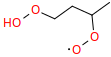

In [15]:
smiles='CC(CCOO)O[O]'
# smiles='CC(CCO[O])OO'

# smiles='C[CH]CCOO'

cmp_sp = rmgpy.species.Species(smiles=smiles)
species_list_original1, reaction_list_original1 = rmgpy.chemkin.load_chemkin_file(mech_1_inp, mech_1_dict, use_chemkin_names=False)
for i in range(len(species_list_original1)):
    if species_list_original1[i].is_isomorphic(cmp_sp):
        print(i, species_list_original1[i])
        display(species_list_original1[i])


In [61]:
reactant =  rmgpy.species.Species(smiles='C[CH]CCOO')
display(reactant)

for i in range(len(species_list_original1)):
    if species_list_original1[i].is_isomorphic(reactant):
        my_reactant = species_list_original1[i]
        print(i, species_list_original1[i])
#         display(species_list_original1[i])
        break
        
for i in range(len(reaction_list_original1)):
    if my_reactant in reaction_list_original1[i].reactants or my_product in reaction_list_original1[i].products:
#         print(i, reaction_list_original1[i])
        display(reaction_list_original1[i])
        print(i, reaction_list_original1[i].get_rate_coefficient(830))
    

170 C4H8OOH1-3


NameError: name 'my_product' is not defined

In [ ]:
reactant =  rmgpy.species.Species(smiles='C[CH]CCOO')
display(reactant)

for i in range(len(species_list_original2)):
    if species_list_original2[i].is_isomorphic(reactant):
        my_reactant = species_list_original2[i]
        print(i, species_list_original2[i])
        break
        
count = 0
for i in range(len(reaction_list_original2)):
    if my_reactant in reaction_list_original2[i].reactants or my_product in reaction_list_original2[i].products:
#         print(i, reaction_list_original1[i])
#         if reaction_list_original2[i].get_rate_coefficient(830, 1013250) > 1e6:
        display(reaction_list_original2[i])
        print(i, reaction_list_original2[i].get_rate_coefficient(830, 1013250))
        count += 1
print(count)

In [ ]:
for i in range(len(species_rates2[99][52, :])):
    if np.abs(species_rates2[99][52, i]) > 1.0e-1:
        print(species_list2[i], species_rates2[99][52, i])
        display(species_list2[i])

In [ ]:
for i in range(len(species_rates1[99][170, :])):
    if np.abs(species_rates1[99][170, i]) > 1.0e-2:
        print(species_list1[i], species_rates1[99][170, i])
        display(species_list1[i])

In [ ]:
reactant =  rmgpy.species.Species(smiles='C[CH]CCOO')
display(reactant)

product =  rmgpy.species.Species(smiles='CC(CCOO)O[O]')
display(product)

In [ ]:
for i in range(len(species_list_original1)):
    if species_list_original1[i].is_isomorphic(reactant):
        my_reactant = species_list_original1[i]
        print(i, species_list_original1[i])
        display(species_list_original1[i])
        break
    
for i in range(len(species_list_original1)):
    if species_list_original1[i].is_isomorphic(product):
        my_product = species_list_original1[i]
        print(i, species_list_original1[i])
        display(species_list_original1[i])
        break
        
for i in range(len(reaction_list_original1)):
    if my_reactant in reaction_list_original1[i].reactants and my_product in reaction_list_original1[i].products or \
        my_reactant in reaction_list_original1[i].products and my_product in reaction_list_original1[i].reactants:
        print(i, reaction_list_original1[i])
        print(i, reaction_list_original1[i].get_rate_coefficient(830))
    

In [ ]:
species_list_original2, reaction_list_original2 = rmgpy.chemkin.load_chemkin_file(mech_2_inp, mech_2_dict, use_chemkin_names=False)


for i in range(len(species_list_original2)):
    if species_list_original2[i].is_isomorphic(reactant):
        my_reactant = species_list_original2[i]
        print(i, species_list_original2[i])
        display(species_list_original2[i])
        break
    
for i in range(len(species_list_original2)):
    if species_list_original2[i].is_isomorphic(product):
        my_product = species_list_original2[i]
        print(i, species_list_original2[i])
        display(species_list_original2[i])
        break
        
for i in range(len(reaction_list_original2)):
    if my_reactant in reaction_list_original2[i].reactants and my_product in reaction_list_original2[i].products or \
        my_reactant in reaction_list_original2[i].products and my_product in reaction_list_original2[i].reactants:
        print(i, reaction_list_original2[i])
        print(i, reaction_list_original2[i].get_rate_coefficient(830))
    
    

In [ ]:
assert len(species_list_original1) == concentrations1.shape[1]


In [ ]:
display(species_list_original1[180])


In [ ]:
display(species_list_original2[71])


In [ ]:
np.max(concentrations2[times2 < t_end, 52]) / np.max(concentrations1[times1 < t_end, 170])

In [ ]:
%matplotlib inline

t_end = 0.01

times1_subset = times1[times1 < t_end]
times2_subset = times2[times2 < t_end]

# plt.plot(times1_subset, concentrations1[times1 < t_end, 180], label=mech_1_label)
# plt.plot(times2_subset, concentrations2[times2 < t_end, 71], label=mech_2_label)

plt.plot(times1_subset, concentrations1[times1 < t_end, 170], label=mech_1_label)
plt.plot(times2_subset, concentrations2[times2 < t_end, 52], label=mech_2_label)


plt.ylabel('concentration')
plt.xlabel('time (s)')
plt.legend()

# Make a bar chart of reactions making SC4H9 and PC4H9

In [72]:
# Make a bar chart of the top reactions going from butane to the two options

butane = database_fun.index2species(4)
display(butane)

pc4h9 = database_fun.index2species(56)
display(pc4h9)

sc4h9 = database_fun.index2species(57)
display(sc4h9)


# get the indices in RMG-7
rmg_butane_index = -1
rmg_pc4h9_index = -1
rmg_sc4h9_index = -1
for i in range(len(species_list2)):
    if species_list2[i].is_isomorphic(butane):
        if rmg_butane_index != -1:
            raise ValueError()
        rmg_butane_index = i
    if species_list2[i].is_isomorphic(pc4h9):
        if rmg_pc4h9_index != -1:
            raise ValueError()
        rmg_pc4h9_index = i
    if species_list2[i].is_isomorphic(sc4h9):
        if rmg_sc4h9_index != -1:
            raise ValueError()
        rmg_sc4h9_index = i

aramco_butane_index = -1
aramco_pc4h9_index = -1
aramco_sc4h9_index = -1
for i in range(len(species_list1)):
    if species_list1[i].is_isomorphic(butane):
        if aramco_butane_index != -1:
            raise ValueError()
        aramco_butane_index = i
    if species_list1[i].is_isomorphic(pc4h9):
        if aramco_pc4h9_index != -1:
            raise ValueError()
        aramco_pc4h9_index = i
    if species_list1[i].is_isomorphic(sc4h9):
        if aramco_sc4h9_index != -1:
            raise ValueError()
        aramco_sc4h9_index = i

# len(species_list2)

Aramco-3
1053


1071


1076


1077


1078


1079


1080


1081


1082


1083


1084


1085


1086


1087


1088


1089


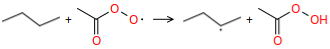

1090


1091


1092


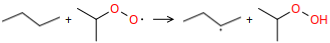

1093


1094


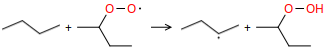

1095


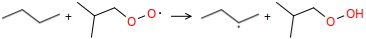

1096


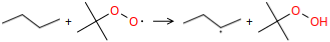


RMG-7
33


34


35


37


37


43


46


55


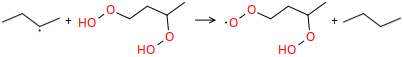

57


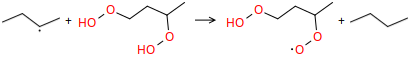

65


66


67


68


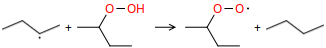

73


77


85


89


92


93


94


94


144


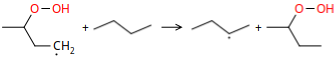

162


187


227


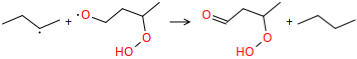

229


263


335


369


374


380


424


442


458


581


631


711


734


767


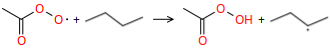

829


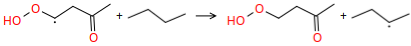

870


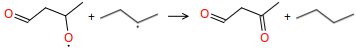

871


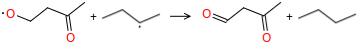

914


972


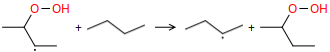

1051


1069


1165


1235


1298


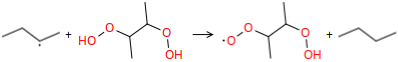

1377


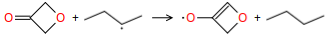

1418


1457


1572


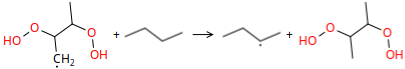

1594


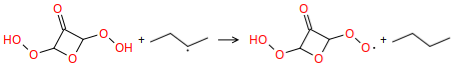

1668


1738


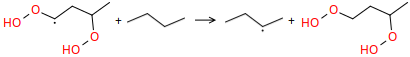

1796


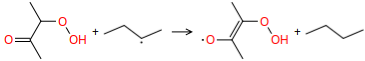

1859


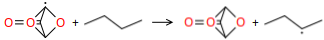

In [155]:
# get the species index

r_index = 4
p_index = 57

ref_r = database_fun.index2species(r_index)
ref_p = database_fun.index2species(p_index)
display(ref_r)
display(ref_p)

rxn_indices = []
fwd_rxn_indices = []
rev_rxn_indices = []
rxn_lists = [reaction_list1, reaction_list2]
rxn_list_labels = ['Aramco-3', 'RMG-7']
for i, rxn_list in enumerate(rxn_lists):
    print(rxn_list_labels[i])
    r_indices = []
    r_fwd = []
    r_rev = []
    for j in range(len(rxn_list)):
        for r in rxn_list[j].reactants:
            if r.is_isomorphic(ref_r):
                for p in rxn_list[j].products:
                    if p.is_isomorphic(ref_p):
                        print(j)
                        display(rxn_list[j])
                        r_indices.append(j)
                        r_fwd.append(j)

            if r.is_isomorphic(ref_p):
                for p in rxn_list[j].products:
                    if p.is_isomorphic(ref_r):
                        print(j)
                        display(rxn_list[j])
                        r_indices.append(j)
                        r_rev.append(j)
    
    rxn_indices.append(r_indices)
    fwd_rxn_indices.append(r_fwd)
    rev_rxn_indices.append(r_rev)

    print()



In [157]:
# Find reactions that have butane and pc4h9 on opposite sides of the equals sign
len(fwd_rxn_indices[1])


18

In [82]:
reaction_rates1.shape

(121, 2921)

In [121]:
def get_label(rxn_list, x):
    try:
        label = str(database_fun.get_unique_reaction_index(rxn_list[x]))
    except IndexError:
        label = str(rxn_list[x])
    return label

In [135]:
rev_rxn_indices[0]

[1071]

t=3.1716027082938986e-05


Text(0.5, 1.0, 'Aramco Butane -> SC4H9 Reactions')

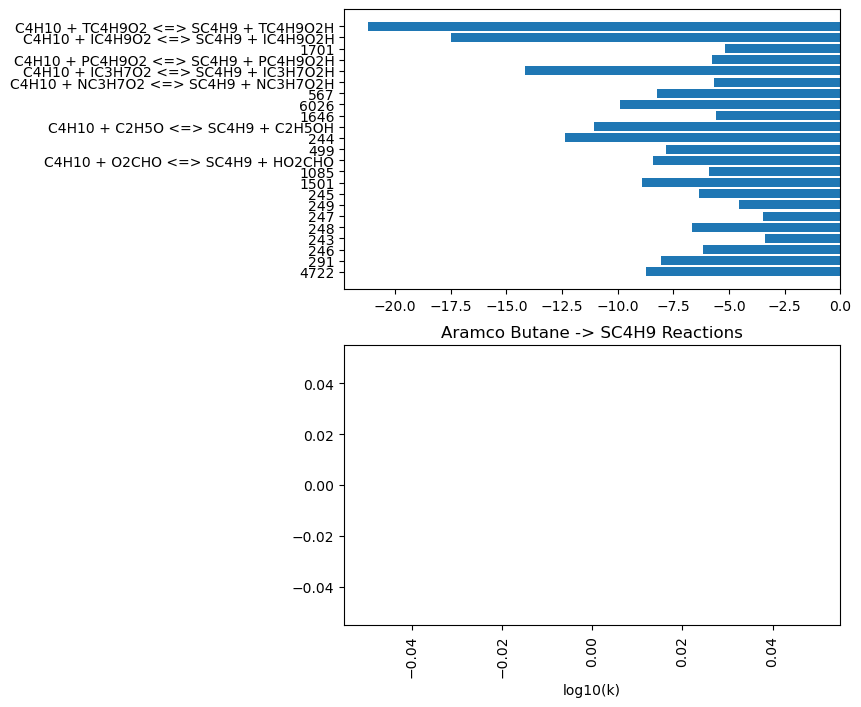

In [160]:
%matplotlib inline
# need 2 bar plots. 1 for forward direction and 1 for reverse
t = 70
print(f't={times1[t]}')

# fwd_values = [reaction_rates1[t, x] for x in fwd_rxn_indices[0]]
# rev_values = [-reaction_rates1[t, x] for x in rev_rxn_indices[0]]


# plt.barh([get_label(reaction_list1, x) for x in list(fwd_values) + list(rev_values)], list(fwd_values) + rev_values, color='red')
# plt.xticks(rotation=90)
# plt.title('Aramco Butane -> PC4H9 Reactions')

fig, axs = plt.subplots(2)

log10fwd_labels = []
log10fwd_values = []
log10rev_labels = []
log10rev_values = []
for x in fwd_rxn_indices[0]:
    if reaction_rates1[t, x] < 0:
        log10rev_values.append(np.log10(-reaction_rates1[t, x]))
        log10rev_labels.append(get_label(reaction_list1, x))
    else:
        log10fwd_values.append(np.log10(reaction_rates1[t, x]))
        log10fwd_labels.append(get_label(reaction_list1, x))
        
        
for x in rev_rxn_indices[0]:
    if reaction_rates1[t, x] < 0:
        log10fwd_values.append(np.log10(-reaction_rates1[t, x]))
        log10fwd_labels.append(get_label(reaction_list1, x))
    else:
        log10rev_values.append(np.log10(reaction_rates1[t, x]))
        log10rev_labels.append(get_label(reaction_list1, x))
plt.sca(axs[0])
plt.barh(log10fwd_labels, log10fwd_values)
plt.sca(axs[1])
plt.xlabel('log10(k)')
plt.barh(log10rev_labels, log10rev_values, color='red')
plt.xticks(rotation=90)
fig.set_figheight(8)
plt.title('Aramco Butane -> SC4H9 Reactions')

t=9.999999999999998e-05


Text(0.5, 1.0, 'RMG-7 Butane -> SC4H9 Reactions')

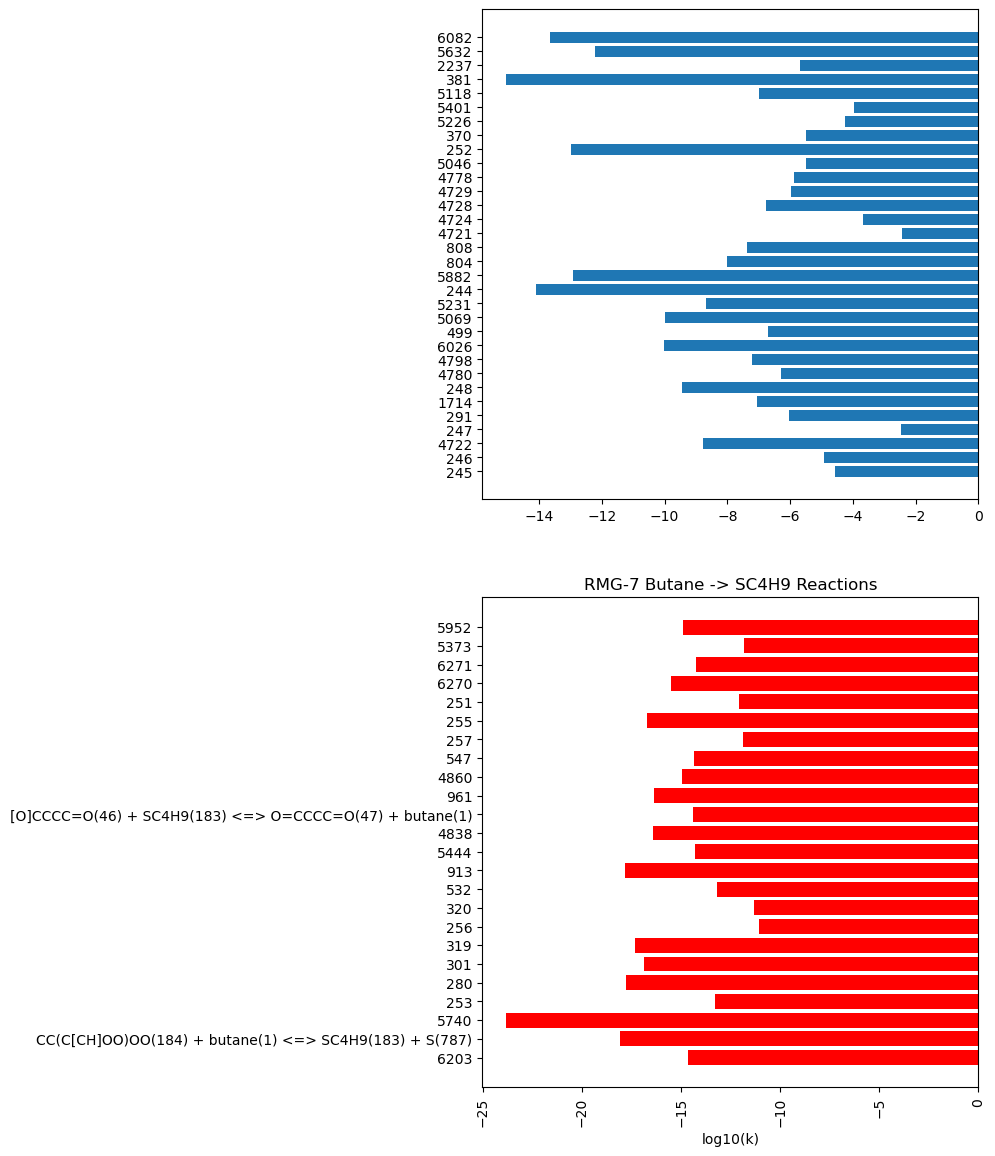

In [159]:
%matplotlib inline
# need 2 bar plots. 1 for forward direction and 1 for reverse
t = 80
print(f't={times1[t]}')
fig, axs = plt.subplots(2)
log10fwd_labels = []
log10fwd_values = []
log10rev_labels = []
log10rev_values = []
for x in fwd_rxn_indices[1]:
    if reaction_rates2[t, x] < 0:
        log10rev_values.append(np.log10(-reaction_rates2[t, x]))
        log10rev_labels.append(get_label(reaction_list2, x))
    else:
        log10fwd_values.append(np.log10(reaction_rates2[t, x]))
        log10fwd_labels.append(get_label(reaction_list2, x))
        
        
for x in rev_rxn_indices[1]:
    if reaction_rates2[t, x] < 0:
        log10fwd_values.append(np.log10(-reaction_rates2[t, x]))
        log10fwd_labels.append(get_label(reaction_list2, x))
    else:
        log10rev_values.append(np.log10(reaction_rates2[t, x]))
        log10rev_labels.append(get_label(reaction_list2, x))

plt.sca(axs[0])
plt.barh(log10fwd_labels, log10fwd_values)
plt.sca(axs[1])
plt.barh(log10rev_labels, log10rev_values, color='red')
plt.xticks(rotation=90)
plt.xlabel('log10(k)')
fig.set_figheight(14) 
plt.title('RMG-7 Butane -> SC4H9 Reactions')

In [139]:
reaction_rates1[10, 1071]

1.8156982943213096e-11

In [136]:
reaction_list1[1071]

In [73]:
reaction_rates1.shape

(121, 2921)

In [128]:
database_fun.index2reaction(291)

In [ ]:
species_list_original2[71].smiles

In [ ]:
cmp_rxn = database_fun.index2reaction(4745)
display(cmp_rxn)

In [ ]:
species_list_original2, reaction_list_original2 = rmgpy.chemkin.load_chemkin_file(mech_2_inp, mech_2_dict, use_chemkin_names=False)
for i in range(len(reaction_list_original2)):
    if reaction_list_original2[i].is_isomorphic(cmp_rxn):
        print(i, reaction_list_original2[i])


In [ ]:
cmp_rxn.reactants[0]

In [ ]:
rxn2_to_universal[48]

In [ ]:
universal_reaction_list[rxn2_to_universal[48]]

In [ ]:
universal_species_list.index(universal_reaction_list[rxn2_to_universal[48]].reactants[0])

In [ ]:
universal_species_list[62]

In [ ]:
universal_species_list.index(universal_reaction_list[rxn2_to_universal[48]].products[0])

In [ ]:
universal_species_list[57]

In [ ]:
# checking the aramco naming...

In [ ]:
smiles = '[CH2]C=C'
smiles = 'C=CCOO'
smiles = 'C=C(C#C)C=C'
smiles = 'CCCC'

cmp = rmgpy.species.Species(smiles=smiles)

for i in range(len(species_list1)):
    if species_list1[i].is_isomorphic(cmp):
        print(i, species_list1[i])


In [ ]:
species_list1[160].label

In [ ]:
str(species_list1[160])

In [ ]:
str(species_list1[160])

In [ ]:
species_list1[160].smiles

In [ ]:
species_list_original2, reaction_list_original2 = rmgpy.chemkin.load_chemkin_file(mech_2_inp, mech_2_dict, use_chemkin_names=False)
cmp_rxn = database_fun.index2reaction(931)
for i in range(len(reaction_list_original2)):
    if reaction_list_original2[i].is_isomorphic(cmp_rxn):
        print(i, reaction_list_original2[i])


In [ ]:
database_fun.get_unique_species_index(species_list1[380])

In [ ]:
rmgpy.species.Species(smiles='CCCC').is_isomorphic(rmgpy.species.Species(smiles='CC(C)C'))

In [ ]:
cmp_rxn = database_fun.index2reaction(931)
species_list_original1, reaction_list_original1 = rmgpy.chemkin.load_chemkin_file(mech_1_inp, mech_1_dict, use_chemkin_names=False)


In [ ]:
for i in range(len(reaction_list_original1)):
    if reaction_list_original1[i].is_isomorphic(cmp_rxn):
        print(i, reaction_list_original1[i])

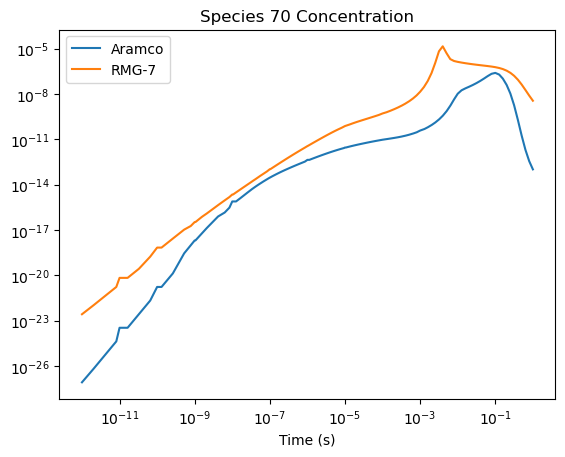

In [165]:
# Plot some species concentrations to try to figure out why RMG-7 accumulates so much #70
%matplotlib inline

sp_index = 70
ref_sp = database_fun.index2species(sp_index)

rmg_index = -1
aramco_index = -1

for i in range(len(species_list1)):
    if species_list1[i].is_isomorphic(ref_sp):
        if aramco_index != -1:
            raise ValueError()
        aramco_index = i
for i in range(len(species_list2)):
    if species_list2[i].is_isomorphic(ref_sp):
        if rmg_index != -1:
            raise ValueError()
        rmg_index = i

display(species_list1[aramco_index])
display(species_list2[rmg_index])

plt.plot(times1, concentrations1[:, aramco_index], label='Aramco')
plt.plot(times2, concentrations2[:, rmg_index], label='RMG-7')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(f'Species {sp_index} Concentration')
plt.xlabel('Time (s)')
plt.legend()

In [99]:
concentrations1[0, 160] - concentrations2[0, 4]

3.552713678800501e-15

In [97]:
species_list1[160]

In [95]:
concentrations2[:, 4]

array([4.54364533, 4.54364533, 4.54364533, 4.54364533, 4.54364533,
       4.54364533, 4.54364533, 4.54364533, 4.54364533, 4.54364533,
       4.54364533, 4.54364533, 4.54364533, 4.54364533, 4.54364533,
       4.54364533, 4.54364533, 4.54364533, 4.54364533, 4.54364533,
       4.54364533, 4.54364533, 4.54364533, 4.54364533, 4.54364533,
       4.54364533, 4.54364533, 4.54364533, 4.54364533, 4.54364533,
       4.54364533, 4.54364533, 4.54364533, 4.54364533, 4.54364533,
       4.54364533, 4.54364533, 4.54364533, 4.54364533, 4.54364533,
       4.54364533, 4.54364533, 4.54364533, 4.54364533, 4.54364533,
       4.54364533, 4.54364533, 4.54364533, 4.54364533, 4.54364533,
       4.54364533, 4.54364533, 4.54364533, 4.54364533, 4.54364533,
       4.54364533, 4.54364533, 4.54364533, 4.54364533, 4.54364533,
       4.54364532, 4.54364532, 4.54364532, 4.54364532, 4.54364532,
       4.54364532, 4.54364531, 4.54364531, 4.5436453 , 4.54364529,
       4.54364528, 4.54364526, 4.54364524, 4.54364521, 4.54364